In [636]:
# import packages
import numpy as np
import os
from matplotlib import pyplot as plt

from SimPEG import maps
from SimPEG.electromagnetics import frequency_domain as fdem
from SimPEG.utils import plot_1d_layer_model 

from SimPEG import (
    maps,
    data,
    data_misfit,
    inverse_problem,
    regularization,
    optimization,
    directives,
    inversion,
)

from discretize import TensorMesh

### Define a 1D layered Model

In [637]:
conductivity_surface = 10e-3
conductivity_middle = 80e-3
conductivity_deep = 40e-3
conductivity_air = 1e-8

print("Top layer conductivity: ", conductivity_surface)
print("Bottom layer conductivity: ", conductivity_deep)

Top layer conductivity:  0.01
Bottom layer conductivity:  0.04


In [638]:
# Define layer thicknesses (m)
layer_thicknesses = np.array([0.2, 0.4])

# Define layer conductivities (S/m)
layer_conductivities = np.r_[conductivity_surface, conductivity_middle, conductivity_deep]

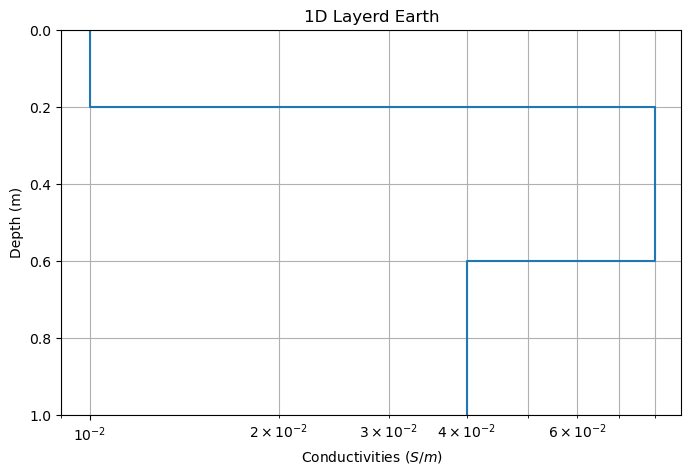

In [639]:
fig, ax = plt.subplots(1, 1, figsize=(8, 5))

ax = plot_1d_layer_model(layer_thicknesses, layer_conductivities, scale="log", ax=ax)
ax.grid(which="both")
ax.set_xlabel(r"Conductivities ($S/m$)")
ax.set_ylim([1, 0])
ax.set_title("1D Layerd Earth")
plt.show()

In [640]:
# LOG-RESISTIVITY MODEL
log_conductivities_model = np.log(layer_conductivities)

# Define the Mappings
log_conductivities_map = maps.ExpMap(nP=len(layer_thicknesses)+1)

### Define Survey

In [641]:
frequencies = 5*np.logspace(3, 6, 5)
coil_separations = np.arange(0.05, 0.7, 0.05)
src_z = 0.10  # src is 0.10m above the surface
orientation_reciever = "x"  # z-oriented dipole for horizontal co-planar loops
orientation_source = "z"
moment  = 1


# reciever offset in 3D space
rx_offsets = np.vstack([np.r_[sep, 0.0, 0.1] for sep in coil_separations])

# create our source list - one source per location
src_loc = np.r_[0.0, 0.0, src_z]
rx_locs = src_loc + rx_offsets

source_list = []
for rx in rx_locs:
    for freq in frequencies:
        receiver_list = []
        receiver_list.append(
            fdem.receivers.PointMagneticFluxDensitySecondary(
                rx,
                orientation=orientation_reciever ,
                component="real",
            )
        )
        receiver_list.append(
            fdem.receivers.PointMagneticFluxDensitySecondary(
                rx,
                orientation=orientation_reciever ,
                component="imag",
            )
        )

        source_list.append(
            fdem.sources.MagDipole(
                    receiver_list=receiver_list,
                    frequency=freq,
                    location=src_loc,
                    orientation=orientation_source,
                    moment=moment,
                )
        )


# Define a 1D FDEM survey
survey = fdem.survey.Survey(source_list)
 

### Define forward simulation



In [642]:
# Define forward simulation

simulation= fdem.Simulation1DLayered(
    survey=survey,
    thicknesses=layer_thicknesses,
    sigmaMap=log_conductivities_map,
)

In [643]:
# Predict 1D FDEM Data
dpred= simulation.dpred(log_conductivities_model)

In [644]:
# fig, ax = plt.subplots(1, 1, figsize=(6, 6))
# ax.loglog(coil_separations, abs(dpred[0::2]), "r-o", lw=3)
# ax.loglog(coil_separations, abs(dpred[1::2]), "b:o", lw=3)
# ax.set_xlabel("Frequency (Hz)")
# ax.set_ylabel("|Bz Secondary| [T]")
# ax.set_title("Magnetic Field Data")
# ax.legend(["Real", "Imaginary"])
# plt.grid()
# plt.show()

In [645]:
# dobs = dpred with uncertainty

noise_level = 0.05 
noise = noise_level * np.abs(dpred) * np.random.rand(len(dpred))
dobs = dpred + noise

### Inversion

In [646]:
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))
data_object = data.Data(survey, dobs=dobs, noise_floor=uncertainties)

In [647]:
# estimated host conductivity (S/m)
estimated_conductivity = 1e-2

In [648]:
depth_min = 0.1  # top layer thickness
depth_max = 1 # depth to lowest layer
geometric_factor = 1.1  # rate of thickness increase

In [649]:
# Increase subsequent layer thicknesses by the geometric factors until
# it reaches the maximum layer depth.
layer_thicknesses_model = [depth_min]
while np.sum(layer_thicknesses_model) < depth_max:
    layer_thicknesses_model.append(geometric_factor * layer_thicknesses_model[-1])

n_layers = len(layer_thicknesses_model) + 1  # Number of layers
print("n_layers: ", n_layers)

n_layers:  9


In [650]:
log_conductivity_map = maps.ExpMap(nP=n_layers)

In [651]:
# Starting model is log-conductivity values (S/m)
starting_conductivity_model = np.log((estimated_conductivity) * np.ones(n_layers))

# Reference model is also log-resistivity values (S/m)
reference_conductivity_model = starting_conductivity_model.copy()

In [652]:
simulation_L2 = fdem.Simulation1DLayered(
    survey=survey, thicknesses=layer_thicknesses_model, sigmaMap=log_conductivity_map
)

### Define Inverse Problem

In [653]:
dmis_L2 = data_misfit.L2DataMisfit(simulation=simulation_L2, data=data_object)

In [654]:
# Define 1D cell widths
h = np.r_[layer_thicknesses_model, layer_thicknesses_model[-1]]
h = np.flipud(h)

# Create regularization mesh
regularization_mesh = TensorMesh([h], "N")
print(regularization_mesh)


  TensorMesh: 9 cells

                      MESH EXTENT             CELL WIDTH      FACTOR
  dir    nC        min           max         min       max      max
  ---   ---  ---------------------------  ------------------  ------
   x      9         -1.34          0.00      0.10      0.19    1.10




In [655]:
reg_L2 = regularization.WeightedLeastSquares(
    regularization_mesh,
    length_scale_x=10.0,
    reference_model=reference_conductivity_model,
    reference_model_in_smooth=False,
)

opt_L2 = optimization.InexactGaussNewton(
    maxIter=100, maxIterLS=20, maxIterCG=20, tolCG=1e-3
)

In [656]:
inv_prob_L2 = inverse_problem.BaseInvProblem(dmis_L2, reg_L2, opt_L2)

In [657]:
update_jacobi = directives.UpdatePreconditioner(update_every_iteration=True)
starting_beta = directives.BetaEstimate_ByEig(beta0_ratio=1e0)
beta_schedule = directives.BetaSchedule(coolingFactor=2.0, coolingRate=3)
target_misfit = directives.TargetMisfit(chifact=1.0)

directives_list_L2 = [
                      update_jacobi, 
                      starting_beta, 
                      beta_schedule, 
                      target_misfit,
                      ]

In [658]:
# Here we combine the inverse problem and the set of directives
inv_L2 = inversion.BaseInversion(inv_prob_L2, directives_list_L2)

# Run the inversion
recovered_model_L2 = inv_L2.run(starting_conductivity_model)


                        SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  4.47e+01  1.64e+04  0.00e+00  1.64e+04    4.18e+03      0              
   1  4.47e+01  4.13e+03  2.34e+00  4.23e+03    1.18e+04      2              
   2  4.47e+01  3.50e+03  5.49e+00  3.74e+03    1.45e+04      0              
   3  2.23e+01  1.08e+02  4.87e+00  2.17e+02    1.63e+03      0              
------------------------- STOP! -------------------------
1 : |fc-fOld| = 0.0000e+00 <= tolF*(1+|f0|) = 1.6358e+03
1 : |xc-x_last| = 2.0259e-01 <= tolX*(1+|x0|) = 1.4816e+00
0 : |proj(x-g)-

In [659]:
# dpred_L2 = simulation_L2.dpred(recovered_model_L2)

# fig = plt.figure(figsize=(10, 5))
# ax = [fig.add_axes([0.1 + ii * 0.5, 0.1, 0.37, 0.85]) for ii in range(2)]
# for ii in range(2):
#     ax[ii].loglog(coil_separations, abs(dobs[ii::2]), "k-o", lw=2)
#     ax[ii].loglog(coil_separations, abs(dpred_L2[ii::2]),"b-o", lw=2)
#     ax[ii].grid(which="both")
#     ax[ii].set_xlabel("Frequency (Hz)")
#     ax[ii].set_ylabel("|Bz Secondary| [T]")
#     ax[ii].legend(["Observed", "L2 Inversion"])
#     if ii == 1:
#         ax[ii].set_ylabel("")

# ax[0].set_title("Real Component")
# ax[1].set_title("Imaginary Component")
# plt.show()

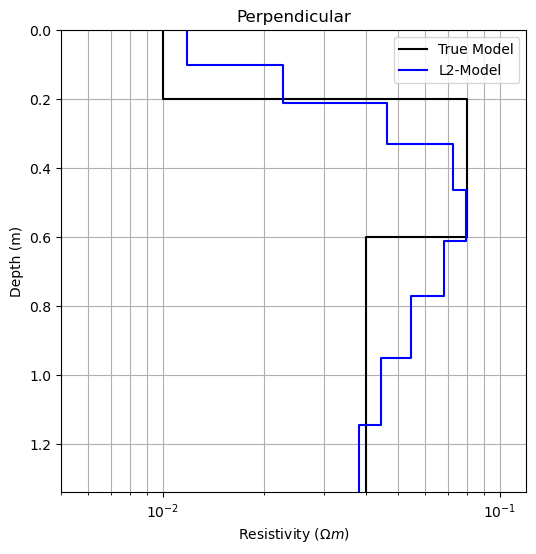

In [660]:
# Plot true model and recovered model
fig, ax = plt.subplots(1,1, figsize=(6, 6))

plot_1d_layer_model(layer_thicknesses, layer_conductivities, scale="log", ax=ax, color="k")
plot_1d_layer_model(layer_thicknesses_model, log_conductivity_map * recovered_model_L2, ax=ax, color="b")
ax.grid(which="both")
ax.set_xlabel(r"Resistivity ($\Omega m$)")
x_min, x_max = layer_conductivities.min(), layer_conductivities.max()
ax.set_xlim(0.5 * x_min, 1.5 * x_max)
ax.legend(["True Model", "L2-Model"])
ax.set_title("Perpendicular")
plt.show()